<a href="https://colab.research.google.com/github/Quan0-cyber/Change-language/blob/main/Logistic_Regression%2C_XGBoost_(input_TF_IDF)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# === cấu hình tên cột ===
CSV_PATH   = "data preprocessing.csv"  # đúng tên file vừa upload
TEXT_COL   = "cleaned_text"
LABEL_COL  = "sentiment_label"

# === đọc csv ===
df = pd.read_csv(CSV_PATH)
print("Các cột có trong file:", list(df.columns))

# lọc dữ liệu hợp lệ
df = df.dropna(subset=[TEXT_COL, LABEL_COL])
df = df[df[TEXT_COL].astype(str).str.strip().astype(bool)].copy()

# chuẩn hoá nhãn về 3 lớp
df[LABEL_COL] = df[LABEL_COL].astype(str).str.lower().str.strip()
mapping = {
    "neg":"negative","negatives":"negative","negative":"negative",
    "neu":"neutral","neutral":"neutral",
    "pos":"positive","positives":"positive","positive":"positive"
}
df[LABEL_COL] = df[LABEL_COL].map(lambda x: mapping.get(x, x))
df = df[df[LABEL_COL].isin(["negative","neutral","positive"])].copy()

print("\nPhân bố nhãn:")
print(df[LABEL_COL].value_counts())

# tạo X_text, y
X_text = df[TEXT_COL].astype(str)
y_raw  = df[LABEL_COL].astype(str)

# encode nhãn
le = LabelEncoder()
y = le.fit_transform(y_raw)            # y là số 0..2
label_names = list(le.classes_)        # ['negative','neutral','positive']
print("\nThứ tự nhãn:", label_names)


Các cột có trong file: ['review_text', 'sentiment_label', 'cleaned_text', 'processed_text', 'sentiment_label.1', 'sentiment_score', 'sentiment_confidence', 'final_rating', 'nps_category', 'season']

Phân bố nhãn:
sentiment_label
positive    2093
negative     344
neutral       62
Name: count, dtype: int64

Thứ tự nhãn: ['negative', 'neutral', 'positive']


In [ ]:
!pip install -q scikit-learn xgboost pandas numpy matplotlib seaborn

from google.colab import files
uploaded = files.upload()  # chọn file: data preprocessing.csv


Saving data preprocessing.csv to data preprocessing (1).csv


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

TEST_SIZE   = 0.2
RANDOM_SEED = 42

# chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# chuyển văn bản thành vector TF-IDF
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),   # unigram + bigram
    min_df=5,            # bỏ từ xuất hiện quá ít
    max_df=0.9           # bỏ từ quá phổ biến
)

Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

print("Kích thước TF-IDF train:", Xtr.shape)
print("Kích thước TF-IDF test:", Xte.shape)


Kích thước TF-IDF train: (1999, 11808)
Kích thước TF-IDF test: (500, 11808)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



[Logistic Regression] Classification Report
              precision    recall  f1-score   support

    negative       0.58      0.36      0.45        69
     neutral       0.50      0.08      0.14        12
    positive       0.88      0.96      0.92       419

    accuracy                           0.86       500
   macro avg       0.65      0.47      0.50       500
weighted avg       0.83      0.86      0.84       500



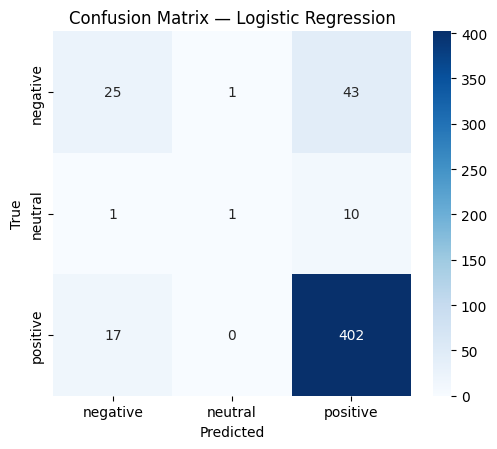


[LogReg] Top features → 'negative':
im, this, very poor, money, to, disappointed, pm, uncomfortable, die, they, disappointing, dirty, not, poor, no

[LogReg] Top features → 'neutral':
over, four star, on room, stayed here, til, limescale, al, my car, bedside, cancelled, la, un, en, central, de

[LogReg] Top features → 'positive':
amazing, helpful, well, comfortable, clean, station, staff, beautiful, excellent, york, good, nice, friendly, great, lovely


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# --- huấn luyện Logistic Regression ---
lr = LogisticRegression(
    max_iter=1500,
    solver='liblinear',       # ổn định cho dữ liệu thưa
    multi_class='ovr',
    class_weight='balanced',  # cân bằng giữa các lớp
    random_state=42
)
lr.fit(Xtr, y_train)

# --- dự đoán ---
y_pred_lr = lr.predict(Xte)

# --- báo cáo ---
print("\n[Logistic Regression] Classification Report")
print(classification_report(y_test, y_pred_lr, target_names=label_names))

# --- Confusion Matrix ---
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=range(len(label_names)))
plt.figure(figsize=(5.2,4.6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# --- Top từ khoá ảnh hưởng đến từng lớp ---
try:
    feats = np.array(tfidf.get_feature_names_out())
    for ci, cname in enumerate(label_names):
        coefs = lr.coef_[ci]
        top_idx = np.argsort(coefs)[-15:]
        print(f"\n[LogReg] Top features → '{cname}':")
        print(", ".join(feats[top_idx]))
except Exception as e:
    print("Skip top features:", e)


Tree method: gpu_hist


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:43:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)



[XGBoost] Classification Report
              precision    recall  f1-score   support

    negative       0.15      0.88      0.26        69
     neutral       0.00      0.00      0.00        12
    positive       0.87      0.20      0.32       419

    accuracy                           0.29       500
   macro avg       0.34      0.36      0.19       500
weighted avg       0.75      0.29      0.31       500



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [16:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [16:43:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: Unde

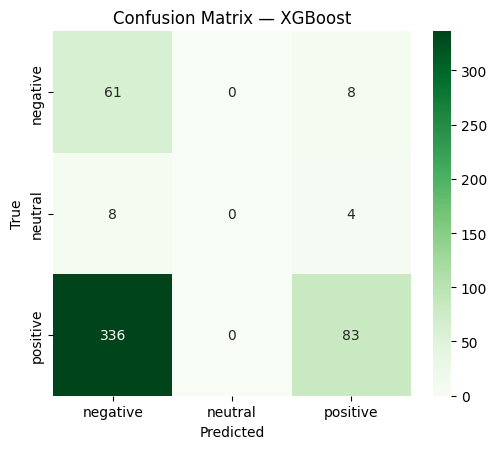

In [ ]:
import os
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# nếu bạn bật GPU: Runtime > Change runtime type > GPU
# thì dùng tree_method='gpu_hist' (nhanh hơn)
tree_method = "gpu_hist" if os.environ.get("COLAB_GPU") else "hist"
print("Tree method:", tree_method)

xgb = XGBClassifier(
    n_estimators=200,     # giảm để chạy nhanh (có thể tăng 300-500 nếu dư thời gian)
    max_depth=6,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=RANDOM_SEED,
    tree_method=tree_method
)

xgb.fit(Xtr, y_train)
y_pred_xgb = xgb.predict(Xte)

print("\n[XGBoost] Classification Report")
print(classification_report(y_test, y_pred_xgb, target_names=label_names))

cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=range(len(label_names)))
plt.figure(figsize=(5.2,4.6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix — XGBoost")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


*italicized text*